# Can we get a diversity of RFs?

Need to probe ideas.

In [19]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import ipr, plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT
from scipy.special import erf

gaussian_cdf = lambda x: 0.5 * (erf(x/np.sqrt(2)) + 1)

File NonlinearGPDataset[-1.00,01.00]_xi=00.10,00.20,00.30,00.40,00.50_gain=100.000_p=0.50_batch_size=1000_num_epochs=2000_loss=mse_lr=0.100_MLPnobias_L=040_K=100_activation=relu_init_scale=0.010_xavier_normal_init.npz not found
Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'adjust': (-1, 1),
 'base_dataset': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'batch_size': 1000,
 'bias_trainable': True,
 'bias_value': 0.0,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'df': None,
 'dim': 1,
 'evaluation_interval': 100,
 'gain': 100,
 'init_fn': <function xavier_normal_init at 0x15b8b0540>,
 'init_scale': 0.01,
 'kwargs': {},
 'learning_rate': 0.1,
 'marginal_adjust': <function <lambda> at 0x15dbf0ea0>,
 'model_cls': <class 'localization.models.feedforward.MLP'>,
 'num_dimensions': 40,
 'num_epochs': 2000,
 'num_hiddens': 100,
 'num_steps': 1000,
 'optimizer_fn': <function sgd a

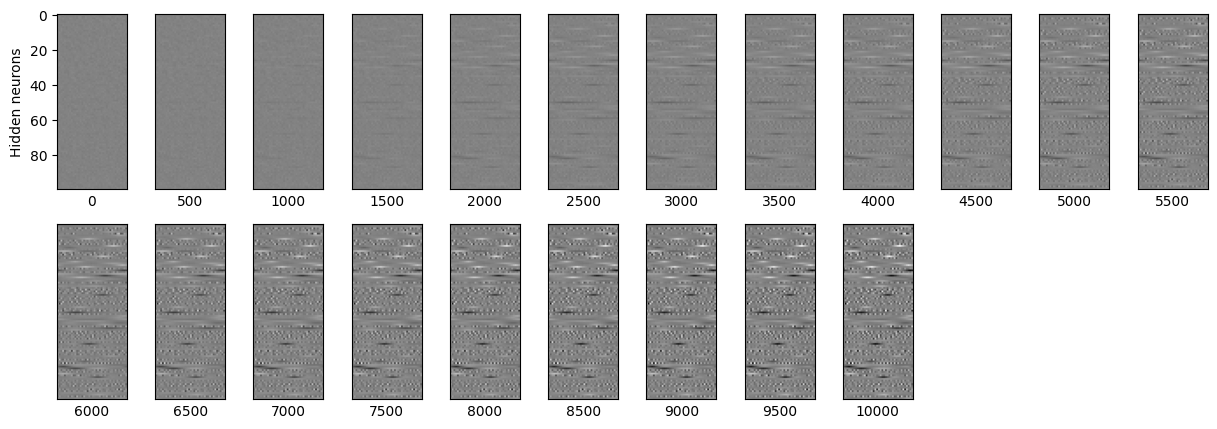

In [35]:
config = dict(
  # data config
  num_dimensions=40,
  # xi=(0.1, 1, 5),
  xi=tuple(list(np.linspace(0.1, 1, 10)) + list(np.linspace(1, 5, 10))),
  adjust=(-1, 1),
  class_proportion=0.5,
  # model config
  # model_cls=models.SimpleNet,
  model_cls=models.MLP,
  activation='relu', use_bias=False, batch_size=1000, init_scale=0.01, learning_rate=0.1, evaluation_interval=100,
  # activation='sigmoid', use_bias=True, bias_value=-1, bias_trainable=False, batch_size=1000, init_scale=0.1, learning_rate=0.1, evaluation_interval=10,
  num_hiddens=100,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  optimizer_fn=optax.sgd,
  num_epochs=2000,
  # experiment config
  seed=42,#0,
  save_=True,
)

DRT = build_DRT(config['num_dimensions'])
num_epochs = config['num_epochs']
lr = config['learning_rate']

# weights_gauss, metrics_gauss = simulate_or_load(**config, gain=100, dataset_cls=datasets.NLGPGaussianCloneDataset)
# _ = plot_rf_evolution(weights_gauss[-10:], figsize=(8, 4))

weights_nlgp, metrics_nlgp = simulate_or_load(**config, gain=100, dataset_cls=datasets.NonlinearGPDataset)
# _ = plot_rf_evolution(weights_nlgp[:,:1], figsize=(8, 4))
_ = plot_receptive_fields(weights_nlgp, num_cols=12, figsize=(15, 5), sort_fn=entropy_sort, ind=-1)

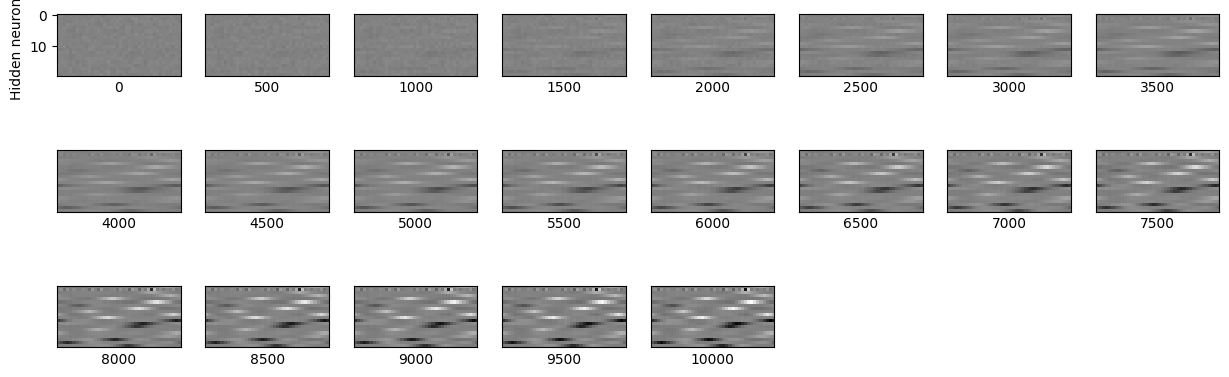

In [40]:
mask = ipr(weights_nlgp[-1]) > 0.15
_ = plot_receptive_fields(weights_nlgp[:, mask, :], num_cols=8, figsize=(15, 5), sort_fn=entropy_sort, ind=-1)

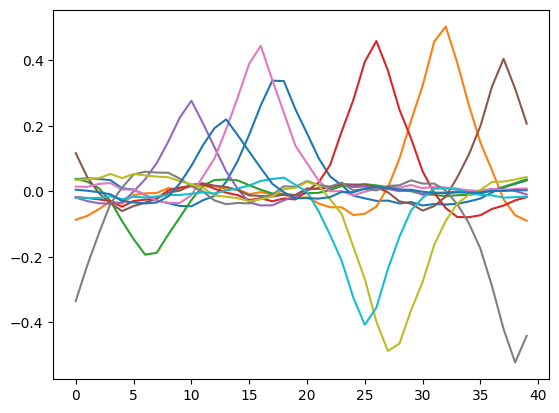

In [55]:
_ = plt.plot(weights_nlgp[-1, mask, :][4:15].T)

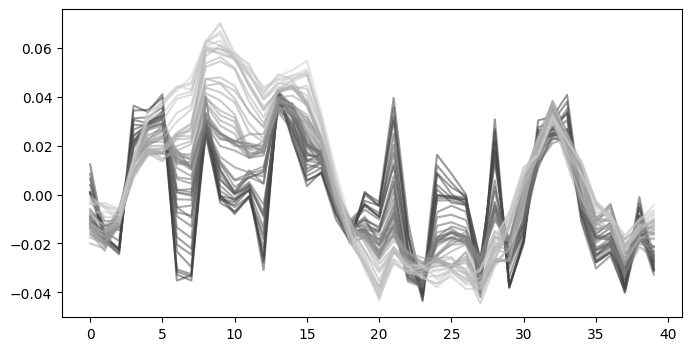

In [ ]:
_ = plot_rf_evolution(weights_nlgp[:50,:1], figsize=(8, 4))

## Exact dynamics

#### Gaussian data

In [8]:
def simulate_gauss(w_init, Sigma1, Sigma0, lr, num_epochs, Sigma1_weight=0.5, Sigma0_weight=0.5):
  num_dimensions = len(w_init)
  w = np.zeros((num_epochs, num_dimensions))
  w[0] = w_init
  sw1_ = np.zeros((num_epochs, num_dimensions))
  sw0_ = np.zeros((num_epochs, num_dimensions))
  f_ = np.zeros((num_epochs, num_dimensions))
  for i in range(1, num_epochs):
    sw1 = Sigma1 @ w[i-1]
    sw0 = Sigma0 @ w[i-1]
    f = np.sqrt(2/np.pi) * sw1 / (w[i-1] @ sw1)
    # f = 0
    w[i] = w[i-1] + 0.5 * lr * (f - (Sigma1_weight * sw1 + Sigma0_weight * sw0))
    # w[i] = w[i-1] + 0.5 * lr * (f - 1.0 * w[i-1])
    sw1_[i] = sw1
    sw0_[i] = sw0
    f_[i] = f
  return w, sw1_, sw0_, f_

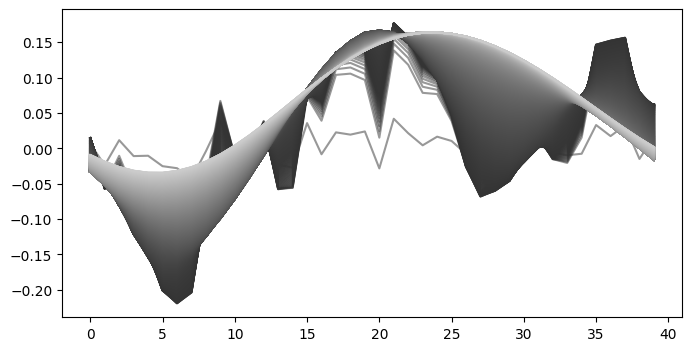

In [4]:
Sigma1 = build_non_gaussian_covariance(40, config['xi'][0], 100)
Sigma0 = build_non_gaussian_covariance(40, config['xi'][1], 100)
lambda1 = np.diag(DRT.T @ Sigma1 @ DRT)
lambda0 = np.diag(DRT.T @ Sigma0 @ DRT)

w_gauss, sw1_gauss, sw0_gauss, f_gauss = simulate_gauss(weights_gauss[0][0], Sigma1, Sigma0, lr, num_epochs, Sigma1_weight=0.5, Sigma0_weight=0.5)
fig, axs = plot_rf_evolution(w_gauss.reshape(-1,1,40), figsize=(8, 4))

Larger in magnitude than I'd have expected from the above, but certainly qualitatively similar.

### High-gain Data

NameError: name 'Sigma1' is not defined

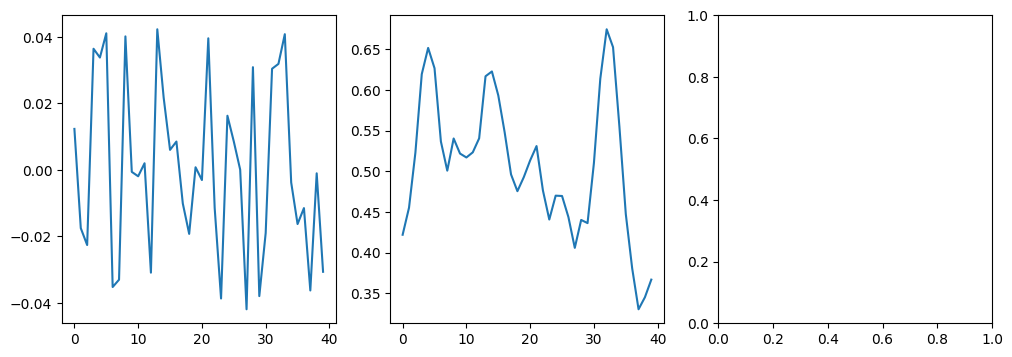

In [9]:
from localization.experiments import simulate_exp
from functools import partial

def prob(x, y, w):
  return 0.5 * jnp.sign(w @ x) * jnp.sign(x) + 0.5

key = jax.random.PRNGKey(0)
dataset = datasets.NonlinearGPDataset(key, xi=(config['xi'][-1],), gain=100, num_dimensions=config['num_dimensions'], num_exemplars=10000)
sampler = samplers.EpochSampler(key, dataset, num_epochs=1)
w = weights_nlgp[0,0]
f = simulate_exp(key, partial(prob, w=w), sampler=sampler, n=10000)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
_ = ax1.plot(w)
_ = ax2.plot(f)
sw1 = Sigma1 @ w
D = 1 / np.sqrt(w @ sw1 -  (sw1 ** 2))
_ = ax3.plot(gaussian_cdf(D * sw1) - 0.5)

In [ ]:
def simulate_nlgp_exact(w_init, Sigma1, Sigma0, lr, num_epochs, Sigma1_weight=0.5, Sigma0_weight=0.5):
  key = jax.random.PRNGKey(0)
  dataset = datasets.NonlinearGPDataset(key, **config)
  sampler = samplers.EpochSampler(key, dataset, num_epochs=1)
  
  num_dimensions = len(w_init)
  w = np.zeros((num_epochs, num_dimensions))
  w[0] = w_init
  sw1_ = np.zeros((num_epochs, num_dimensions))
  sw0_ = np.zeros((num_epochs, num_dimensions))
  D_ = np.zeros((num_epochs, num_dimensions))
  f_ = np.zeros((num_epochs, num_dimensions))
  for i in range(1, num_epochs):
    print(i)
    sw1 = Sigma1 @ w[i-1]
    sw0 = Sigma0 @ w[i-1]
    D = 1 / np.sqrt(w[i-1] @ sw1 -  (sw1 ** 2))
    f = simulate_exp(key, partial(prob, w=w[i-1]), sampler=sampler, n=1000)
    w[i] = w[i-1] + 0.5 * lr * (f - (Sigma1_weight * sw1 + Sigma0_weight * sw0))
    sw1_[i] = sw1
    sw0_[i] = sw0
    D_[i] = D
    f_[i] = f
  return w, sw1_, sw0_, D_, f_

In [24]:
Sigma1 = build_non_gaussian_covariance(40, config['xi'][0], 100)
Sigma0 = build_non_gaussian_covariance(40, config['xi'][1], 100)
lambda1 = np.diag(DRT.T @ Sigma1 @ DRT)
lambda0 = np.diag(DRT.T @ Sigma0 @ DRT)

w_nlgp, sw1_nlgp, sw0_nlgp, D_nlgp, f_nlgp = simulate_nlgp_exact(weights_nlgp[0][0], Sigma1, Sigma0, lr, num_epochs, Sigma1_weight=0.5, Sigma0_weight=0.5)
fig, axs = plot_rf_evolution(w_nlgp[::10].reshape(-1,1,40), figsize=(8, 4))

1
simulate_exp: (1000, 40)


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape bool[].
The problem arose with the `int` function. If trying to convert the data type of a value, try using `x.astype(int)` or `jnp.array(x, int)` instead.
This BatchTracer with object id 5882646976 was created on line:
  /var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_18266/2346471048.py:5:13 (prob)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

## Approximate Dynamics

### High-gain data

In [442]:
algsiginv = lambda x: x / np.sqrt(1 - x ** 2)
testf = lambda x: erf(1/np.sqrt(2) * algsiginv(x))
# testf = lambda x: np.where(np.abs(x) < 0.5, np.sqrt(2/np.pi) * x, np.sign(x) * 1.25 * (np.abs(x) - 0.1))
# testf = lambda x: np.sqrt(2/np.pi) * x * np.exp(0.1 * np.abs(x))
# testf = lambda x: np.sqrt(2/np.pi) * x * np.exp(0.01 * np.abs(x))
# m = 0.92; b = (np.sqrt(2/np.pi)-m)/2; testf = lambda x: np.where(np.abs(x) < 0.5, np.sqrt(2/np.pi) * x, m * x + np.sign(x) * b)
# testf = lambda x: 0.5 * (erf(5 * (x-0.65)) + 1)
# testf = lambda x: np.sqrt(2/np.pi) * x + 0.05 * x ** 3
# testf = lambda x: np.sqrt(2/np.pi) * x - 0.05 * x ** 3
def simulate_nlgp(w_init, Sigma1, Sigma0, lr, num_epochs, Sigma1_weight=0.5, Sigma0_weight=0.5):
  num_dimensions = len(w_init)
  w = np.zeros((num_epochs, num_dimensions))
  w[0] = w_init
  sw1_ = np.zeros((num_epochs, num_dimensions))
  sw0_ = np.zeros((num_epochs, num_dimensions))
  D_ = np.zeros((num_epochs, num_dimensions))
  f_ = np.zeros((num_epochs, num_dimensions))
  # m = 0.3 ### BEWARE OF REDEFINING m ###
  for i in range(1, num_epochs):
    sw1 = (Sigma1 @ w[i-1]).astype(np.complex64)
    sw0 = (Sigma0 @ w[i-1]).astype(np.complex64)
    # D = 1 / np.sqrt(w[i-1] @ sw1 -  (sw1 ** 2))
    D = 1 / np.sqrt((w[i-1]).astype(np.complex64) @ sw1 -  (sw1 ** 2))
    # f = gaussian_cdf(1.0 * D * sw1) - 0.5
    # f = 0.5 * erf(D * sw1 / np.sqrt(2))
    # f = 0.5 * erf(sw1 / np.sqrt(w[i-1] @ sw1 -  (sw1 ** 2)) / np.sqrt(2))
    # f = 0.5 * erf((sw1 / np.sqrt(np.abs(w[i-1] @ sw1))) / np.sqrt(np.sign(w[i-1] @ sw1) -  (sw1 ** 2) / np.abs(w[i-1] @ sw1)) / np.sqrt(2))
    
    # f = 0.5 * erf((sw1 / np.sqrt(w[i-1] @ sw1)) / np.sqrt(1 - (sw1 ** 2) / (w[i-1] @ sw1)) / np.sqrt(2))
    # f = 0.5 * erf((sw1 / np.sqrt(-(w[i-1] @ sw1))) / np.sqrt(-(1 - (sw1 ** 2) / (w[i-1] @ sw1))) / np.sqrt(2))
    # f = 0.5 * ( erf((sw1 / np.sqrt(w[i-1] @ sw1)) / np.sqrt(1 - (sw1 ** 2) / (w[i-1] @ sw1)) / np.sqrt(2))).real
    # f = 0.5 * ( erf(algsiginv(sw1 / np.sqrt(w[i-1] @ sw1)) / np.sqrt(2))).real
    # f = 0.5/m * ( erf(algsiginv(sw1 / np.sqrt(np.abs(w[i-1] @ sw1)) * m) / np.sqrt(2)))
    # f = 0.5 * ( erf(algsiginv(sw1 / np.sqrt(np.abs(w[i-1] @ sw1))) / 1.3))
    f = 0.5 * testf(sw1 / np.sqrt(np.abs(w[i-1] @ sw1)))
    # f = 0.5 * testf(sw1 / 0.5)
    # f = 0.5 * sw1 / 0.5
    # f = 0.5 * testf(sw1 / np.linalg.norm(w[i-1]))
    # f = 0.5 * ( erf(algsiginv(w[i-1] / np.linalg.norm(w[i-1])) / np.sqrt(2)))
    # f = 0.5 * 1.2 * (sw1 / np.sqrt(w[i-1] @ sw1) / np.sqrt(2)).real
    # f = 0.5 * (d-0.1) * sw1 / np.sqrt(np.abs(w[i-1] @ sw1))
    # f = 0.5 * d * sw1 / 0.7645390288227789
    
    # m = sw1 / (w[i-1] @ sw1)
    # m = np.where(m > 1, 1-1e-3, np.where(m < -1, -1+1e-3, m))
    # f = 0.5 * erf(1 / algsiginv(m) / np.sqrt(2))
    # f = D * sw1
    # f = 0
    w[i] = w[i-1] + 0.5 * lr * (f.real - (Sigma1_weight * sw1.real + Sigma0_weight * sw0.real))
    # w[i] = w[i-1] + 0.5 * lr * (f - 1.0 * w[i-1])
    sw1_[i] = sw1.real
    sw0_[i] = sw0.real
    D_[i] = D.real
    f_[i] = f.real
  return w, sw1_, sw0_, D_, f_

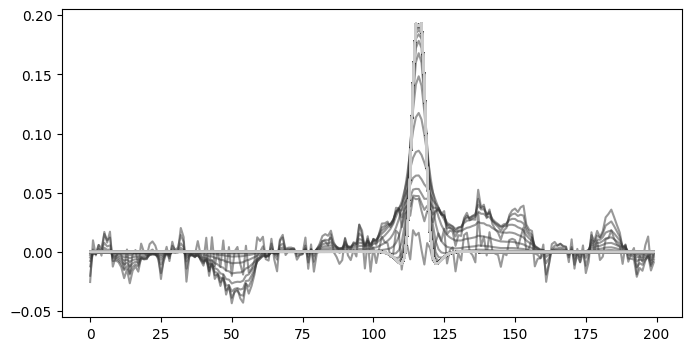

In [443]:
n = 200
DRT = build_DRT(n)
Sigma1 = build_non_gaussian_covariance(n, 2 * config['xi'][1], 100)
Sigma0 = build_non_gaussian_covariance(n, config['xi'][0], 100)
lambda1 = np.diag(DRT.T @ Sigma1 @ DRT)
lambda0 = np.diag(DRT.T @ Sigma0 @ DRT)

# w = weights_nlgp[0][0]#.copy()
# w = np.zeros(n); w[n//2] = 0.1; w[3*n//4] = 0.05 #0.09999
w = jax.random.normal(jax.random.PRNGKey(0), (n,)) * 0.01
# w += 0.1
w_nlgp, sw1_nlgp, sw0_nlgp, D_nlgp, f_nlgp = simulate_nlgp(w, Sigma1, Sigma0, 5 * lr, 2 * num_epochs, Sigma1_weight=0.5, Sigma0_weight=0.5)
fig, axs = plot_rf_evolution(w_nlgp[::5].reshape(-1,1,n), figsize=(8, 4))

In [444]:
w_nlgp[-1]

array([ 7.39076055e-19,  5.17429856e-19,  3.14008979e-19,  1.64268092e-19,
        6.94034002e-20,  1.72663161e-20, -6.59299703e-21, -1.41828953e-20,
       -1.38215079e-20, -1.05076042e-20, -6.82432568e-21, -3.83859343e-21,
       -1.79270213e-21, -5.58598036e-22,  1.01054193e-22,  4.02734823e-22,
        4.87814721e-22,  4.04977763e-22,  1.06769509e-22, -5.47051233e-22,
       -1.77222356e-21, -3.80640811e-21, -6.78034455e-21, -1.04588587e-20,
       -1.37894255e-20, -1.42137062e-20, -6.77003226e-21,  1.68126495e-20,
        6.84978313e-20,  1.62723332e-19,  3.11719292e-19,  5.14565950e-19,
        7.36430938e-19,  8.74569583e-19,  7.10094127e-19, -1.48511775e-19,
       -2.30950978e-18, -6.58304742e-18, -1.38206627e-17, -2.44697032e-17,
       -3.76488212e-17, -4.95247459e-17, -5.08350728e-17, -2.36639797e-17,
        6.17985577e-17,  2.48590194e-16,  5.88507586e-16,  1.12511873e-15,
        1.85419811e-15,  2.64879188e-15,  3.13671293e-15,  2.52708426e-15,
       -5.92195779e-16, -

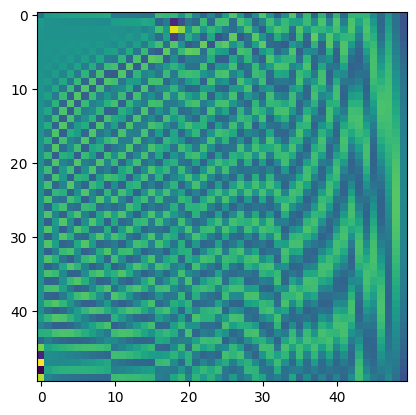

In [437]:
_ = plt.imshow(np.linalg.eigh(np.diag(d) @ Sigma1)[1])

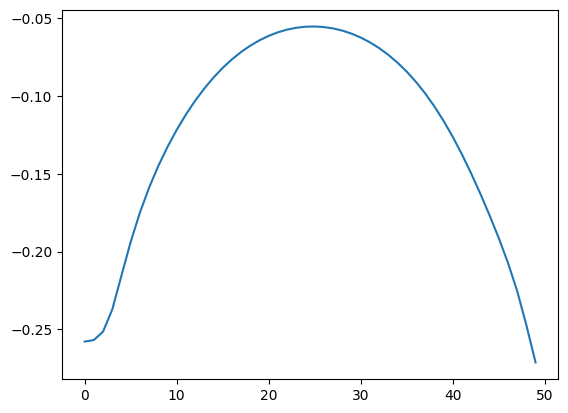

In [440]:
_ = plt.plot(np.linalg.eigh(np.diag(d) @ Sigma1)[1][:,-1:])

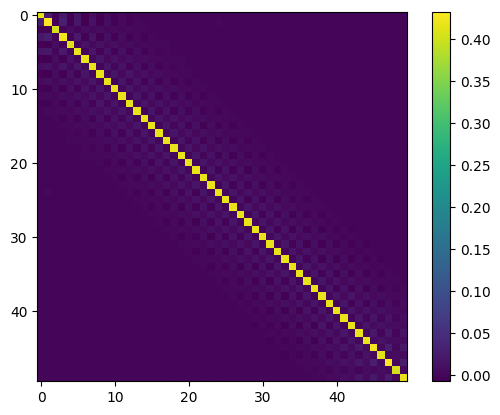

In [421]:
im = plt.imshow(DRT.T @ np.diag(d) @ DRT)
cbar = plt.colorbar(im)

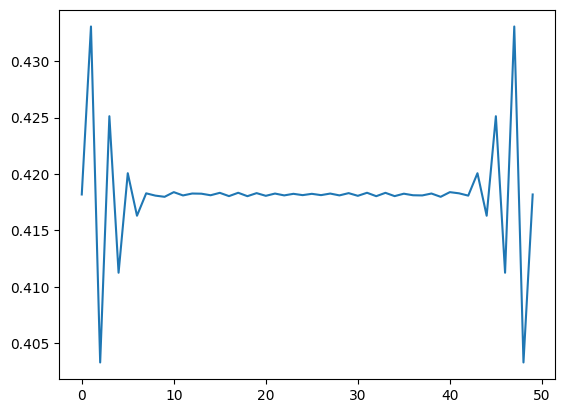

In [422]:
_ = plt.plot(np.diag(DRT.T @ np.diag(d) @ DRT))

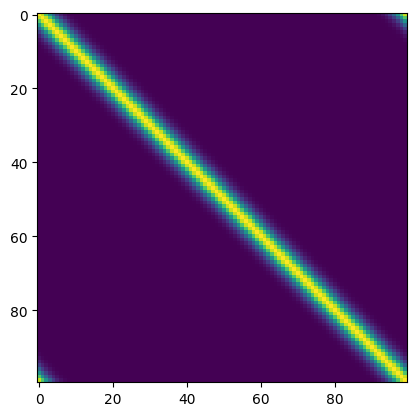

In [380]:
_ = plt.imshow(Sigma1.T @ Sigma1)

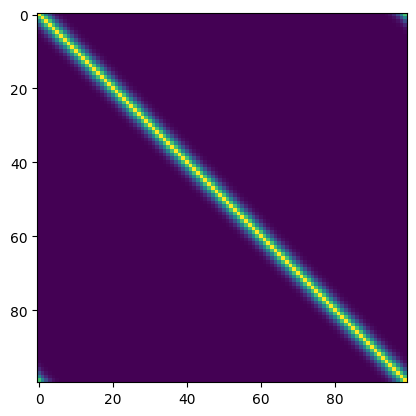

In [381]:
_ = plt.imshow(Sigma1)

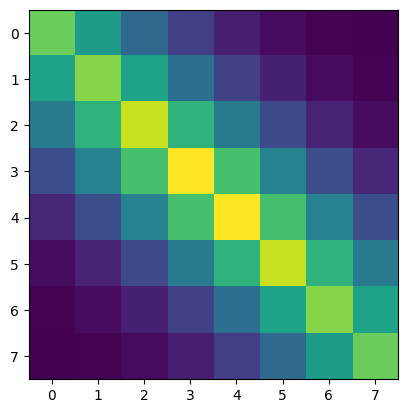

In [386]:
m_ = d > (np.sqrt(1/2/np.pi) + 0.005)
_ = plt.imshow((np.diag(d) @ Sigma1)[m_][:,m_])

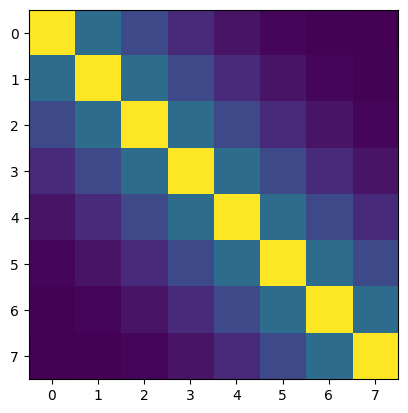

In [387]:
_ = plt.imshow((Sigma0 + Sigma1)[m_][:,m_])

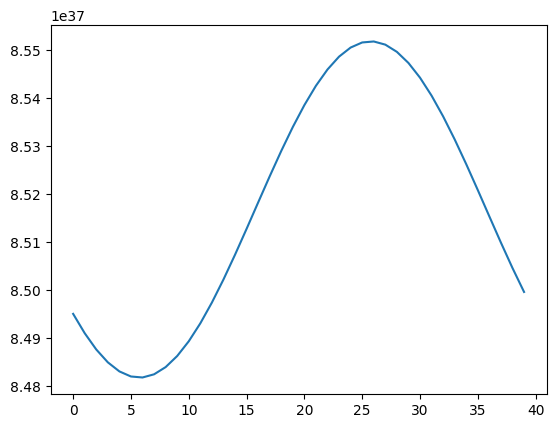

In [317]:
_ = plt.plot(w_nlgp[np.where(np.isnan(w_nlgp).sum(axis=1) == 0)[0][-1]])

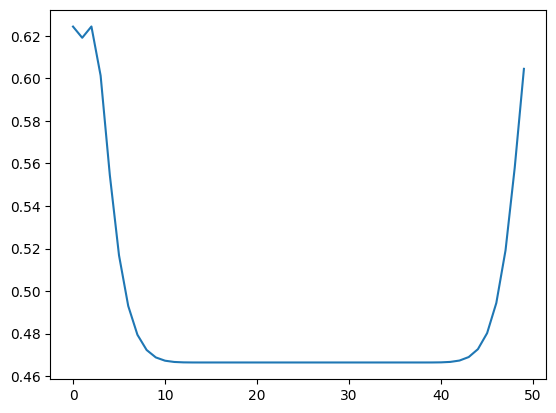

In [423]:
# _ = plt.plot(f_nlgp[-1])
# _ = plt.plot(sw1_nlgp[-1] / np.sqrt(w_nlgp[-1] @ sw1_nlgp[-1]))
d = f_nlgp[-1] / (sw1_nlgp[-1] / np.sqrt(w_nlgp[-1] @ sw1_nlgp[-1]))
_ = plt.plot(d / np.sqrt(w_nlgp[-1] @ sw1_nlgp[-1]))

In [401]:
np.sqrt(w_nlgp[-1] @ sw1_nlgp[-1])

0.8552583917491621

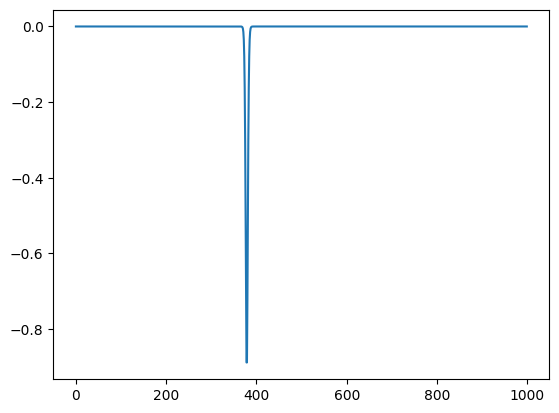

In [358]:
_ = plt.plot(sw1_nlgp[-1] / np.sqrt(w_nlgp[-1] @ sw1_nlgp[-1]))

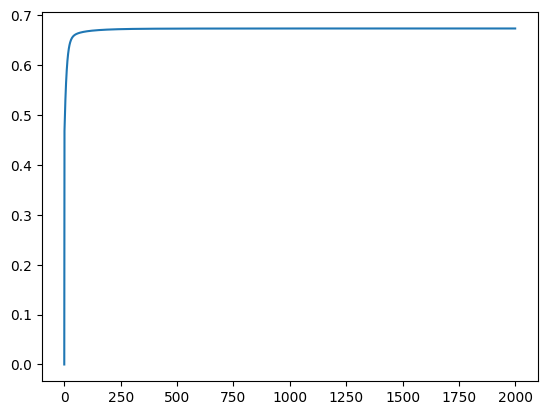

In [289]:
w1norm = np.sqrt(np.sum(w_nlgp * sw1_nlgp, axis=1))
# finner1 = sw1_nlgp / w1norm[:,None]
# _ = plt.plot(finner1)
# _ = plt.xscale('log')
_ = plt.plot(w1norm)

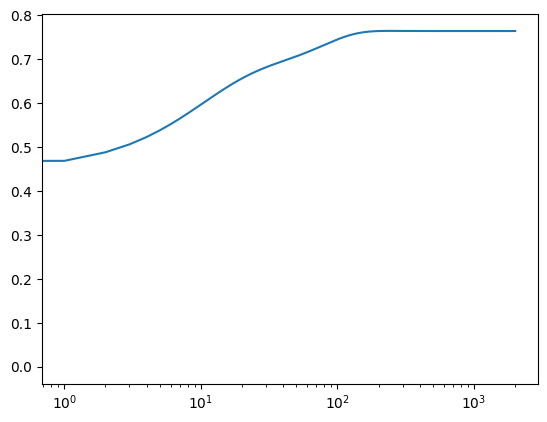

In [234]:
_ = plt.plot(w1norm)
_ = plt.xscale('log')

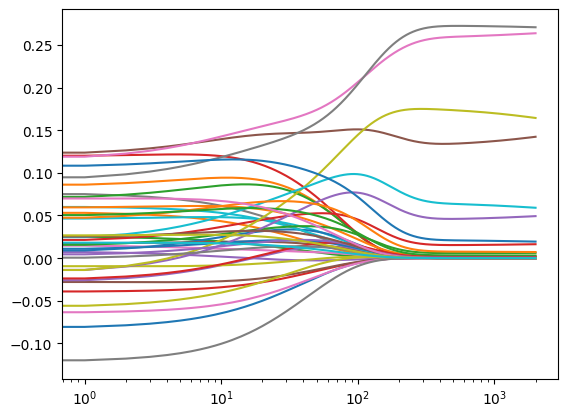

In [231]:
_ = plt.plot(w_nlgp)
_ = plt.xscale('log')

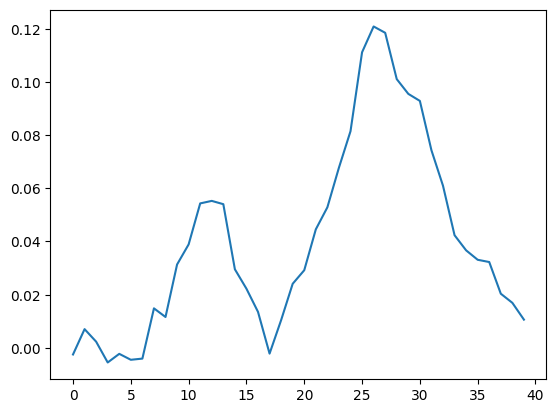

In [226]:
_ = plt.plot(w_nlgp[100])

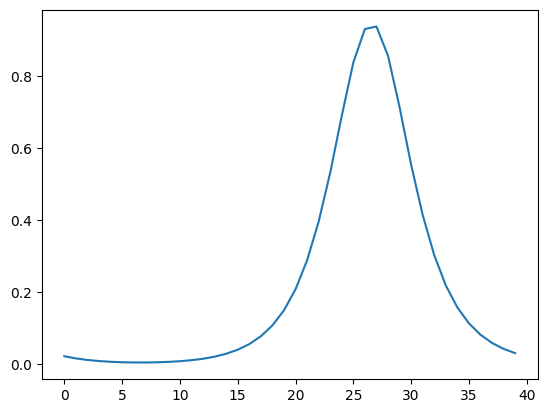

In [193]:
_ = plt.plot(sw1_nlgp[-1] / (sw1_nlgp[-1] @ w_nlgp[-1]))

In [158]:
w_nlgp[-1]

array([0.0023323 , 0.00167275, 0.00121262, 0.00089703, 0.00068835,
       0.00056168, 0.00050191, 0.00050192, 0.0005617 , 0.00068838,
       0.00089707, 0.00121266, 0.0016728 , 0.00233236, 0.00327004,
       0.00459772, 0.00647352, 0.00912016, 0.01285286, 0.01812638,
       0.02560171, 0.03616494, 0.05072386, 0.0696758 , 0.09225936,
       0.1881035 , 0.21003324, 0.21003318, 0.18810347, 0.09225932,
       0.06967568, 0.0507238 , 0.03616489, 0.02560166, 0.0181263 ,
       0.01285279, 0.0091201 , 0.00647345, 0.00459765, 0.00326998])

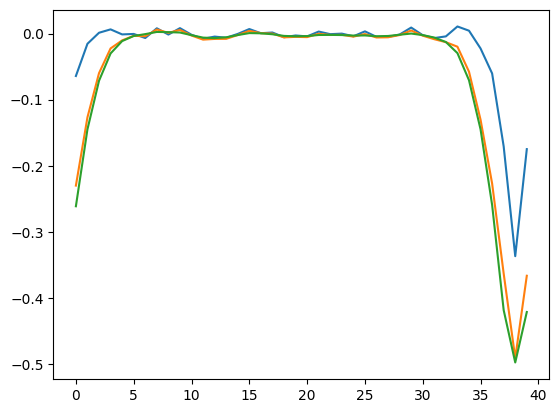

In [150]:
w = weights_nlgp[-1,0]
_ = plt.plot(w)
# _ = plt.plot(Sigma0 @ weights_nlgp[-1,0])
_ = plt.plot(0.5 * (Sigma0 + Sigma1) @ w)
sw1 = Sigma1 @ w
D = 1 / np.sqrt(w @ sw1 -  (sw1 ** 2))
_ = plt.plot(gaussian_cdf(D * sw1) - 0.5)

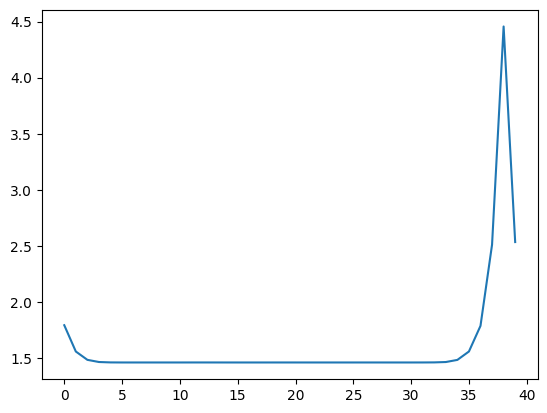

In [151]:
_ = plt.plot(D)

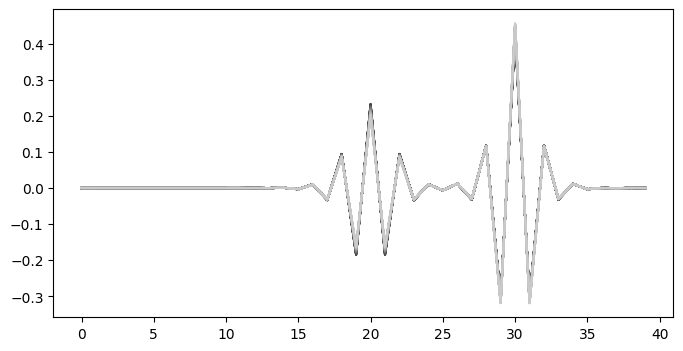

In [134]:
fig, axs = plot_rf_evolution(w_nlgp[4500:4600].reshape(-1,1,40), figsize=(8, 4))

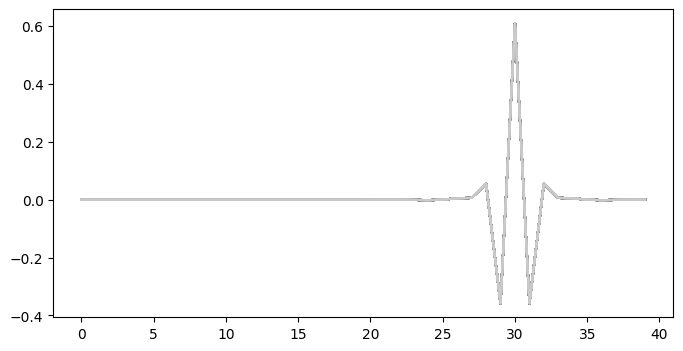

In [126]:
fig, axs = plot_rf_evolution(w_nlgp[-100:].reshape(-1,1,40), figsize=(8, 4))

We want to find the steady state:
$$
\frac{d}{dt} w = f(w) - \frac{1}{2} (\Sigma_0 + \Sigma_1) w
= \underbrace{ \begin{bmatrix} w^\top \Sigma_1 w - ( k_i^\top w )^2 \end{bmatrix}_{ii}^{-\frac{1}{2}} }_{\triangleq D} \Sigma_1 w - \frac{1}{2} (\Sigma_0 + \Sigma_1) w \equiv 0
$$
Then, we have
$$
\frac{1}{2} (\Sigma_0 + \Sigma_1) w
= \begin{bmatrix} \frac{1}{ \sqrt{ w^\top \Sigma_1 w - ( k_i^\top w )^2 } } \end{bmatrix}_{ii} \Sigma_1 w
= \frac{ 1 }{ \sqrt{ w^\top \Sigma_1 w } } \begin{bmatrix} \frac{1}{ \sqrt{ 1 - \frac{ ( k_i^\top w )^2 }{ w^\top \Sigma_1 w } } } \end{bmatrix}_{ii} \Sigma_1 w.
$$
Analyzing one entry at a time:
$$
\frac{1}{2} (k_i^{(0)} + k_i^{(1)})^\top w
= \frac{ (k_i^{(1)})^\top w }{ \sqrt{ w^\top \Sigma_1 w - ( (k^{(1)}_i)^\top w )^2 } }
= \frac{ 1 }{ \sqrt{ \frac{ w^\top \Sigma_1 w }{ ( (k^{(1)}_i)^\top w )^2 } - 1 } }
$$


<!-- Note that
$$
\frac{1}{ \sqrt{ 1 - \frac{ ( k_i^\top w )^2 }{ w^\top \Sigma_1 w } } }
\approx 1 + \frac{1}{2} \frac{ ( k_i^\top w )^2 }{ w^\top \Sigma_1 w },
$$
when $\frac{ ( k_i^\top w )^2 }{ w^\top \Sigma_1 w }$ is small. -->



<!-- So,
$$
D \Sigma_1 w = \frac{1}{2} (\Sigma_0 + \Sigma_1) w
\iff
D P \Lambda_1 u = \frac{1}{2} P (\Lambda_0 + \Lambda_1) u
$$ -->

In [495]:
D_nlgp[-1] * sw1_nlgp[-1] - 0.5 * (sw1_nlgp[-1] + sw0_nlgp[-1])

array([-3.44514461e-09, -1.86196356e-08,  1.09855397e-09, -6.26453361e-10,
        1.37777099e-10, -3.45945889e-11,  4.21647298e-12, -1.09367433e-12,
        2.78968021e-13, -3.47212362e-14,  4.40296620e-15, -1.03188899e-15,
        2.72336081e-16, -4.49353101e-16,  4.76233387e-16, -4.80310186e-16,
        4.57457488e-16, -4.09106208e-16,  3.33316487e-16, -2.27396952e-16,
        8.99696059e-17,  7.69813598e-17, -2.62347766e-16,  4.40502922e-16,
       -4.73421941e-16,  1.12784573e-15, -4.23751716e-15,  3.32190025e-14,
       -2.75566482e-13,  1.05999543e-12, -4.45498402e-12,  3.61529136e-11,
       -1.41574932e-10,  5.38974324e-10, -1.79072743e-09, -1.93181275e-08,
        1.40896539e-09,  5.47345550e-07,  2.44916077e-06,  5.21410332e-07])

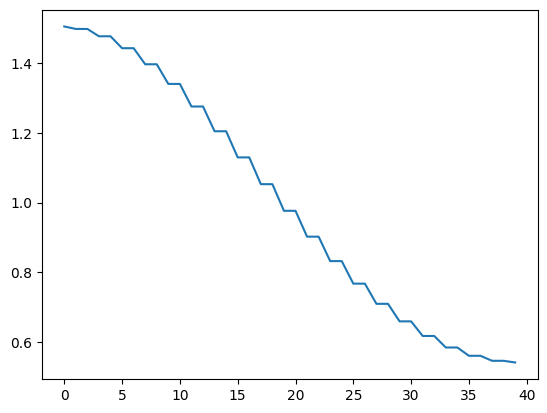

In [506]:
_ = plt.plot(lambda0)

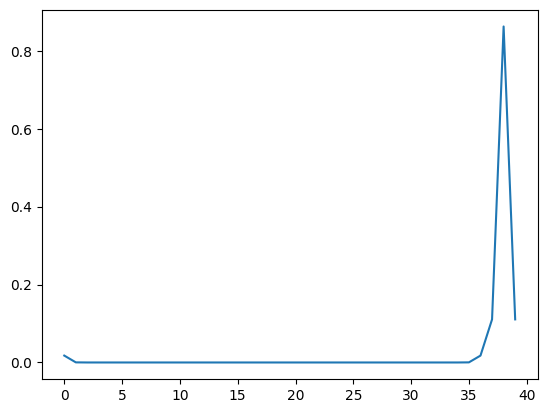

In [505]:
_ = plt.plot( ((Sigma1 @ w_nlgp[-2]) ** 2) / (w_nlgp[-2] @ Sigma1 @ w_nlgp[-2]) )

In [497]:
( 1 / np.sqrt(w_nlgp[-2] @ Sigma1 @ w_nlgp[-2] - ((Sigma1 @ w_nlgp[-2]) ** 2)) ) * sw1_nlgp[-1] - 0.5 * (sw1_nlgp[-1] + sw0_nlgp[-1])

array([-3.44514461e-09, -1.86196356e-08,  1.09855397e-09, -6.26453361e-10,
        1.37777099e-10, -3.45945889e-11,  4.21647298e-12, -1.09367433e-12,
        2.78968021e-13, -3.47212362e-14,  4.40296620e-15, -1.03188899e-15,
        2.72336081e-16, -4.49353101e-16,  4.76233387e-16, -4.80310186e-16,
        4.57457488e-16, -4.09106208e-16,  3.33316487e-16, -2.27396952e-16,
        8.99696059e-17,  7.69813598e-17, -2.62347766e-16,  4.40502922e-16,
       -4.73421941e-16,  1.12784573e-15, -4.23751716e-15,  3.32190025e-14,
       -2.75566482e-13,  1.05999543e-12, -4.45498402e-12,  3.61529136e-11,
       -1.41574932e-10,  5.38974324e-10, -1.79072743e-09, -1.93181275e-08,
        1.40896539e-09,  5.47345550e-07,  2.44916077e-06,  5.21410332e-07])

In [503]:
1 / ( np.sqrt(w_nlgp[-2] @ Sigma1 @ w_nlgp[-2]) * np.sqrt(1 - ((Sigma1 @ w_nlgp[-2]) ** 2) / (w_nlgp[-2] @ Sigma1 @ w_nlgp[-2])) ) * sw1_nlgp[-1] - 0.5 * (sw1_nlgp[-1] + sw0_nlgp[-1])

array([-3.44514461e-09, -1.86196356e-08,  1.09855397e-09, -5.07806464e-10,
        1.37777099e-10, -3.45945889e-11,  4.21647298e-12, -1.09367433e-12,
        2.78968021e-13, -3.47212362e-14,  4.40296620e-15, -1.03188899e-15,
        2.72336081e-16, -4.49353101e-16,  4.76233387e-16, -4.80310186e-16,
        4.57457488e-16, -4.09106208e-16,  3.33316487e-16, -2.27396952e-16,
        8.99696059e-17,  7.69813598e-17, -2.62347766e-16,  4.40502922e-16,
       -4.73421941e-16,  1.12784573e-15, -4.23751716e-15,  3.32190025e-14,
       -2.75566482e-13,  1.05999543e-12, -4.45498402e-12,  3.61529136e-11,
       -1.41574932e-10,  6.57621180e-10, -1.79072743e-09, -1.93181275e-08,
        1.40896539e-09,  5.47345550e-07,  2.44916077e-06,  5.21410332e-07])

Pretty close!

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_78590/301099449.py:8: RuntimeWarning: divide by zero encountered in divide
  D = 1 / np.sqrt(w_ @ sw -  (sw ** 2))


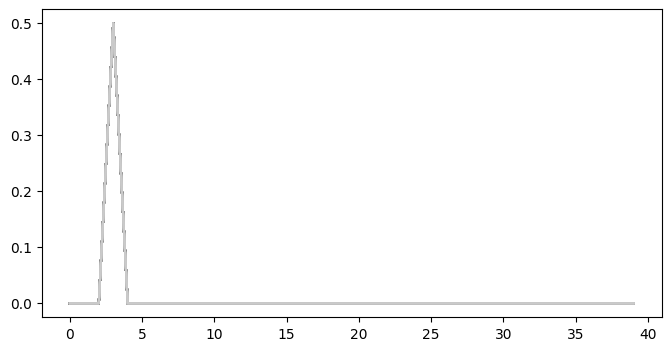

In [352]:
def just_f(w_init, Sigma, lr, num_epochs):
  num_dimensions = len(w_init)
  w = np.zeros((num_epochs, num_dimensions))
  w[0] = w_init
  for i in range(1, num_epochs):
    w_ = w[i-1] #/ (np.linalg.norm(w[i-1]) + 1e-8)
    sw = Sigma @ w_
    D = 1 / np.sqrt(w_ @ sw -  (sw ** 2))
    dw = gaussian_cdf(D * sw) - 0.5
    w_ = (1 - lr) * w_ + lr * dw
    w[i] = w_ #/ (np.linalg.norm(w_) + 1e-8)
  return w
w_init = jax.random.normal(jax.random.PRNGKey(20), (40,))
# w_init = weights_gauss[0][0]
w = just_f(w_init, Sigma1, lr, num_epochs)
_ = plot_rf_evolution(w[-100:].reshape(-1,1,40), figsize=(8, 4))

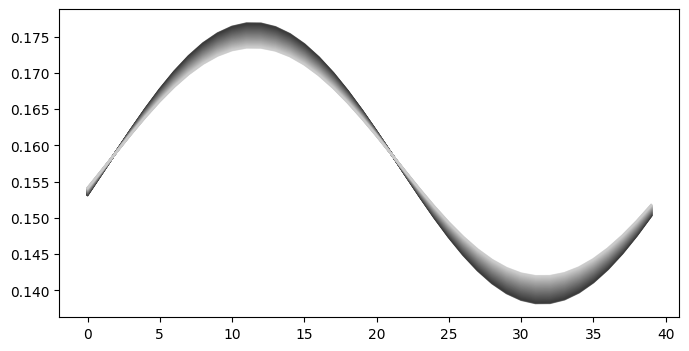

In [347]:
def just_f_gauss(w_init, Sigma, lr, num_epochs):
  num_dimensions = len(w_init)
  w = np.zeros((num_epochs, num_dimensions))
  w[0] = w_init
  for i in range(1, num_epochs):
    w_ = w[i-1] #/ (np.linalg.norm(w[i-1]) + 1e-8)
    sw = Sigma @ w_
    dw = sw / (w_ @ sw)
    w_ = (1 - lr) * w_ + lr * dw
    w[i] = w_ #/ (np.linalg.norm(w_) + 1e-8)
  return w
# w_init = jax.random.normal(jax.random.PRNGKey(3), (40,))
w_init = weights_gauss[0][0]
w = just_f_gauss(w_init, Sigma1, lr, num_epochs)
_ = plot_rf_evolution(w[-100:].reshape(-1,1,40), figsize=(8, 4))

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_78590/1126200267.py:8: RuntimeWarning: divide by zero encountered in divide
  D = 1 / np.sqrt(w_ @ sw -  (sw ** 2))


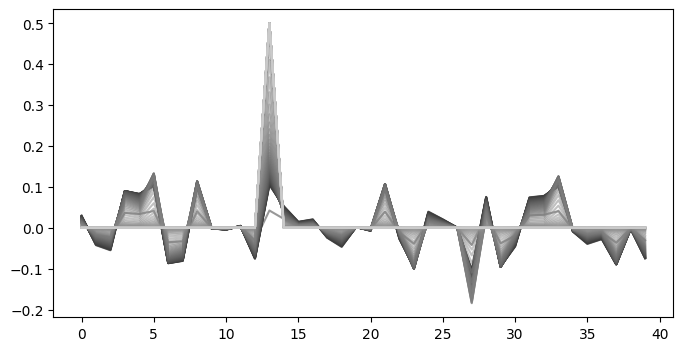

In [341]:
def power_f(w_init, Sigma, num_epochs):
  num_dimensions = len(w_init)
  w = np.zeros((num_epochs, num_dimensions))
  w[0] = w_init
  for i in range(1, num_epochs):
    w_ = w[i-1] #/ (np.linalg.norm(w[i-1]) + 1e-8)
    sw = Sigma @ w_
    D = 1 / np.sqrt(w_ @ sw -  (sw ** 2))
    w[i] = gaussian_cdf(D * sw) - 0.5
    # w[i] = D * sw1
  return w
# w_init = jax.random.normal(jax.random.PRNGKey(3), (40,))
w_init = weights_gauss[0][0]
w = power_f(w_init, np.eye(40), num_epochs)
_ = plot_rf_evolution(w[:100].reshape(-1,1,40), figsize=(8, 4))

### Evolution of normal weights

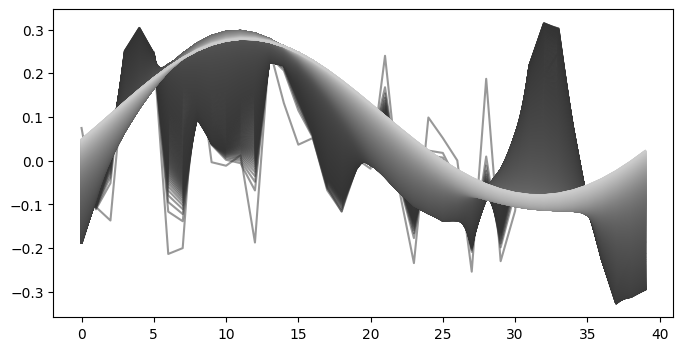

In [194]:
fig, axs = plot_rf_evolution((w_gauss / np.linalg.norm(w_gauss, axis=1, keepdims=True)).reshape(-1,1,40), figsize=(8, 4))

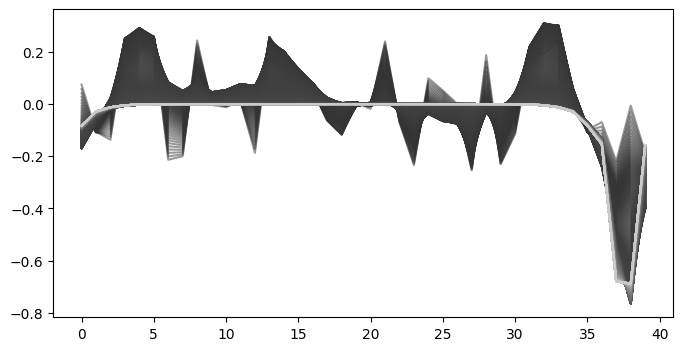

In [197]:
fig, axs = plot_rf_evolution((w_nlgp / np.linalg.norm(w_nlgp, axis=1, keepdims=True)).reshape(-1,1,40), figsize=(8, 4))

### Studying order parameters

$ w^\top \Sigma_1 w $

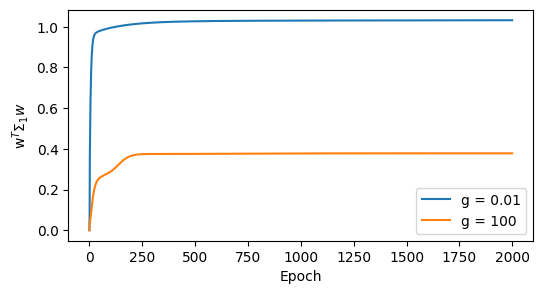

In [186]:
w1_norm_gauss = np.sum(w_gauss * sw1_gauss, axis=1)
w1_norm_nlgp = np.sum(w_nlgp * sw1_nlgp, axis=1)
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(w1_norm_gauss, label=r'g = 0.01')
ax.plot(w1_norm_nlgp, label=r'g = 100')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'w$^T \Sigma_1 w$')
ax.legend()

$w^\top \Sigma_0 w$

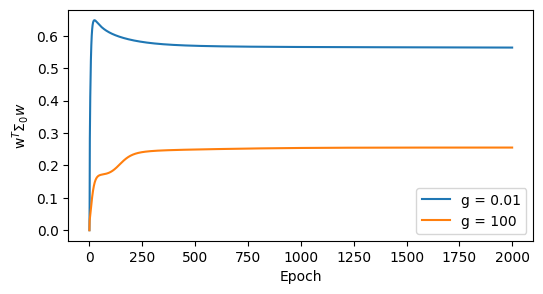

In [187]:
w0_norm_gauss = np.sum(w_gauss * sw0_gauss, axis=1)
w0_norm_nlgp = np.sum(w_nlgp * sw0_nlgp, axis=1)
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(w0_norm_gauss, label=r'g = 0.01')
ax.plot(w0_norm_nlgp, label=r'g = 100')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'w$^T \Sigma_0 w$')
ax.legend()

$(w^\top k_i)^2$

Text(0, 0.5, '(w$^T k_i)^2$')

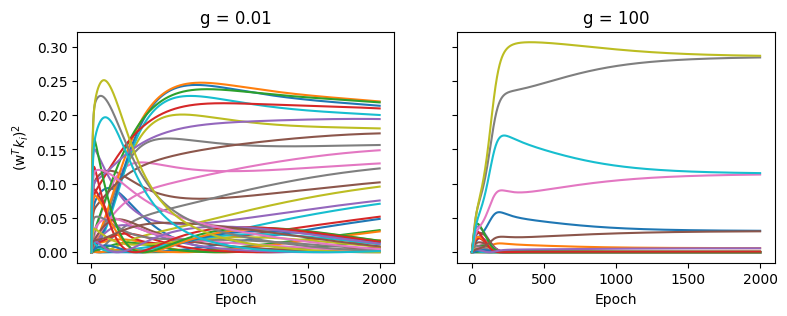

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
ax1.plot(sw1_gauss ** 2, label='Gauss')
ax2.plot(sw1_nlgp ** 2, label='NLGP')
ax1.set_xlabel('Epoch'); ax2.set_xlabel('Epoch')
ax1.set_title(r'g = 0.01'); ax2.set_title(r'g = 100')
ax1.set_ylabel(r'(w$^T k_i)^2$')

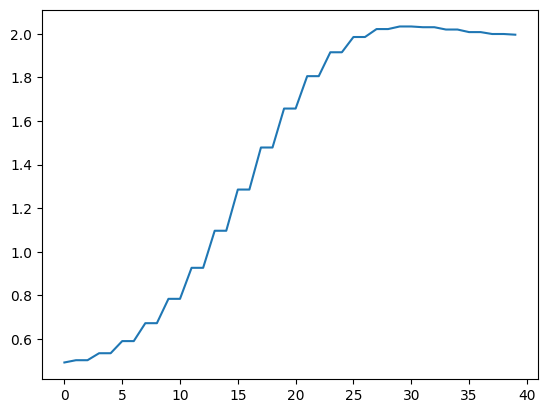

In [189]:
_ = plt.plot( 4 * (lambda1 / lambda0 + 1) ** -2 )

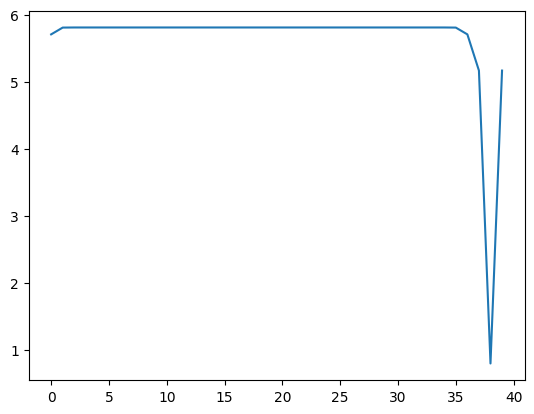

In [174]:
_ = plt.plot( (w1_norm_nlgp.reshape(-1,1) - (sw1_nlgp ** 2))[-1] )

In [176]:
np.argsort( (w1_norm_nlgp.reshape(-1,1) - (sw1_nlgp ** 2))[-1] - 4 * (lambda1 / lambda0 + 1) ** -2 )

array([38, 37, 39, 36, 30, 29, 32, 31, 28, 27, 34, 33, 35, 26, 25, 24, 23,
       22, 21, 20, 19, 17, 18, 16, 15, 13, 14, 11, 12,  9, 10,  7,  8,  0,
        6,  5,  3,  4,  1,  2])

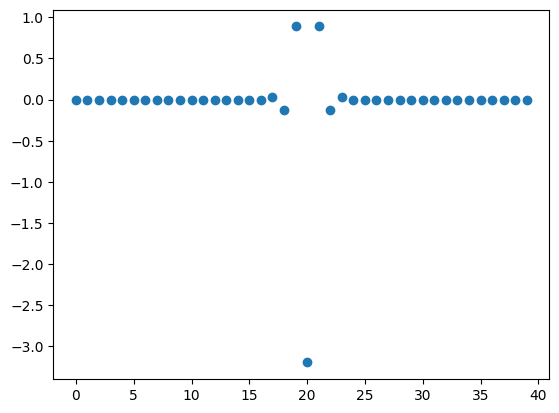

In [177]:
_ = plt.plot(np.roll(w_nlgp[-1], -18), 'o')

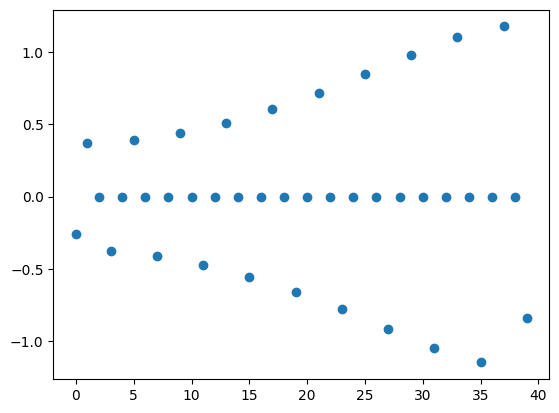

In [178]:
_ = plt.plot(DRT.T @ np.roll(w_nlgp[-1], -18), 'o')

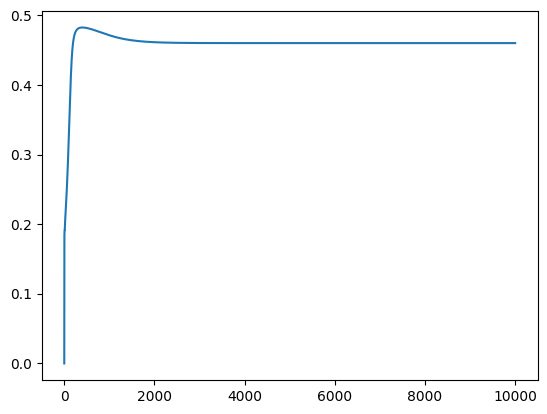

In [60]:
_ = plt.plot(np.abs(f_).max(axis=1))

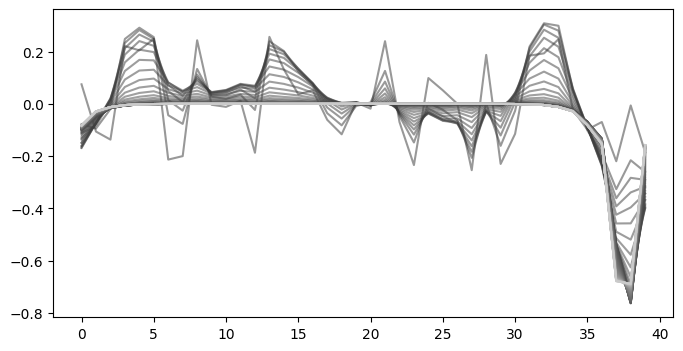

In [74]:
w_norm = w / np.sqrt((w ** 2).sum(axis=1)).reshape(-1,1)
fig, axs = plot_rf_evolution(w_norm[:2000:20].reshape(-1, 1, 40), figsize=(8, 4))

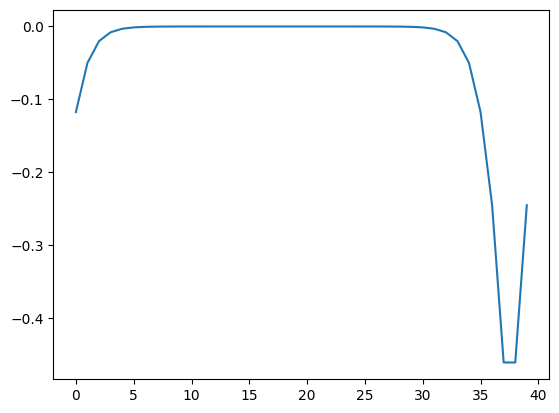

In [56]:
_ = plt.plot(f)

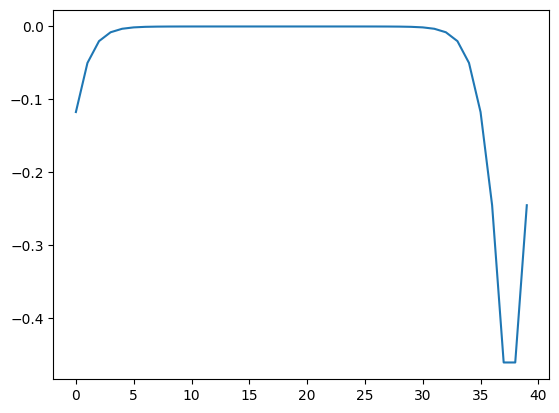

In [58]:
_ = plt.plot(0.5 * (sw0_[-1] + sw1_[-1]))

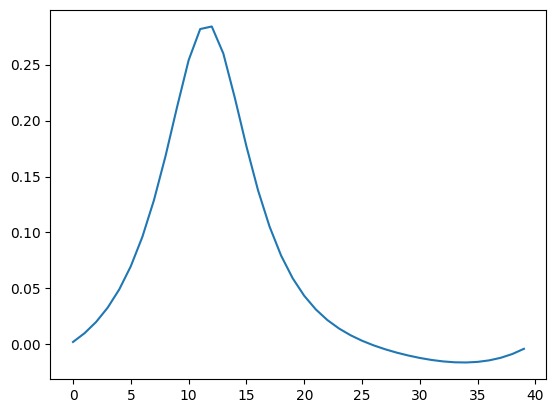

In [51]:
plt.plot(w[-1])

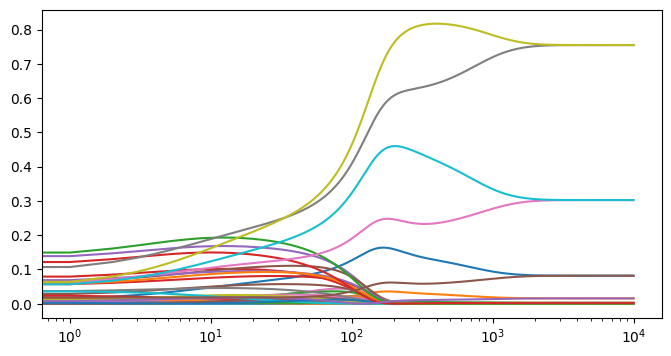

In [78]:
d = (sw1_ ** 2) / ((w * sw1_).sum(axis=1).reshape(-1,1) + 1e-8)
# fig, axs = plot_rf_evolution(d.reshape(-1,1,40), figsize=(8, 4))
fig, ax = plt.subplots(figsize=(8, 4))
_ = ax.plot(d)
_ = ax.set_xscale('log')

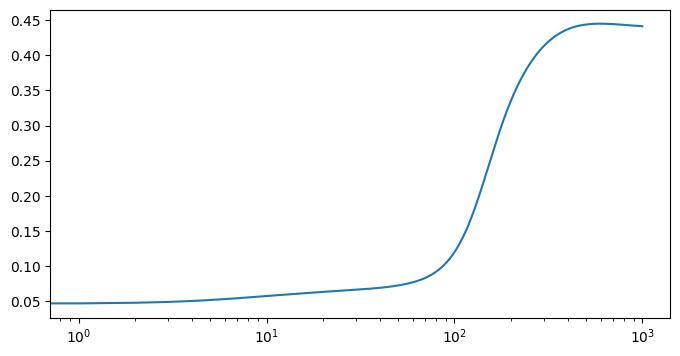

In [17]:
ipr = (w ** 4).sum(axis=1) / ((w ** 2).sum(axis=1) ** 2)
fig, ax = plt.subplots(figsize=(8, 4))
_ = ax.plot(ipr)
_ = ax.set_xscale('log')

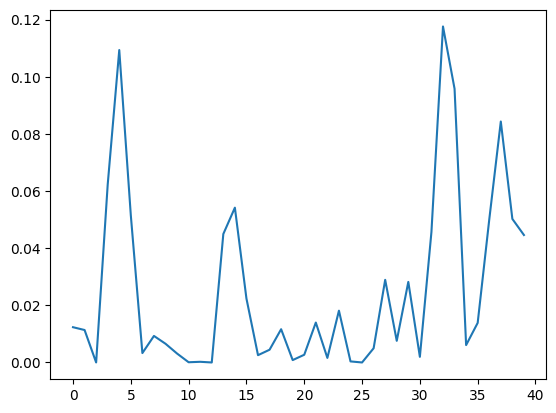

In [148]:
_ = plt.plot(d[1])

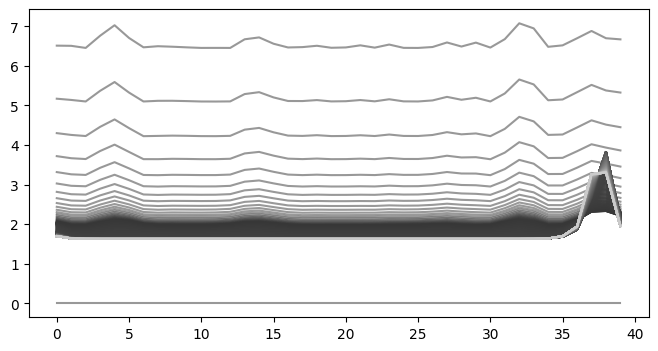

In [111]:
fig, axs = plot_rf_evolution(D_.reshape(-1,1,40), figsize=(8, 4))

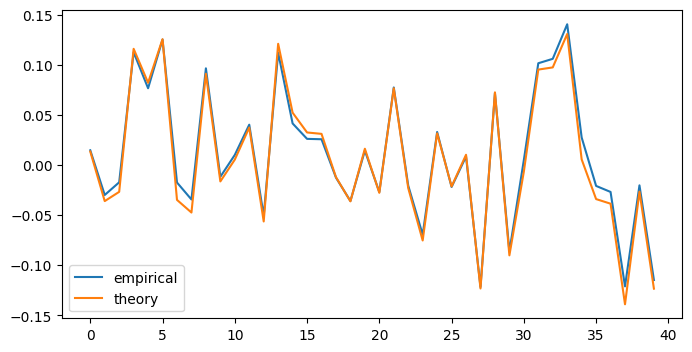

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(weights[5,0], label='empirical')
ax.plot(w[50], label='theory')
ax.legend()

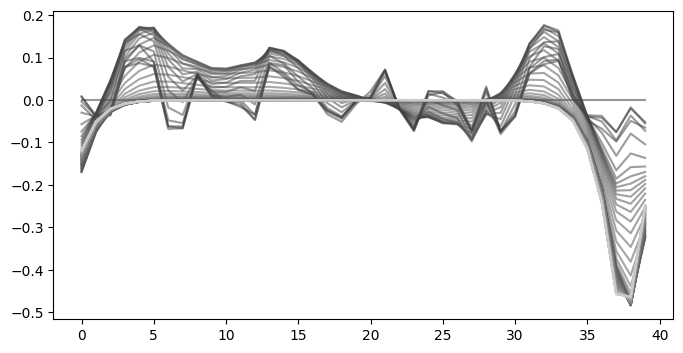

In [60]:
fig, axs = plot_rf_evolution(f_[::10].reshape(-1,1,40), figsize=(8, 4))

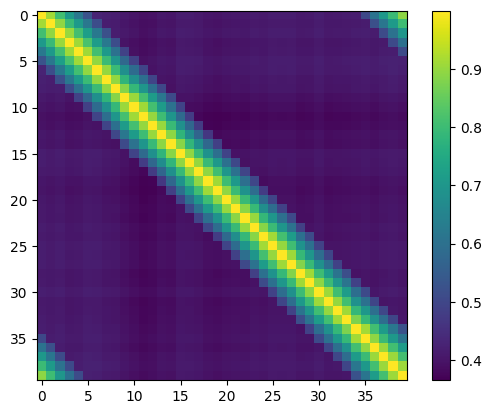

In [45]:
xx1 = (x1.T @ x1) / len(x1)
s1 = xx1 - np.outer(m1, m1)
im = plt.imshow(s1)
cbar = plt.colorbar(im)

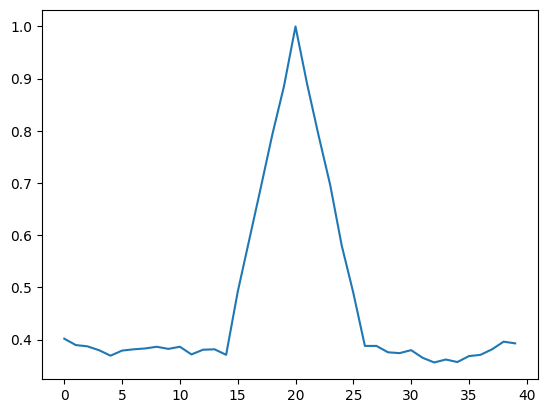

In [128]:
x1_ = x1[x1[:,20] == 1]
m1_ = _ = np.mean(x1_, axis=0)
xx1_ = (x1_.T @ x1_) / len(x1_)
_ = plt.plot(m1_)

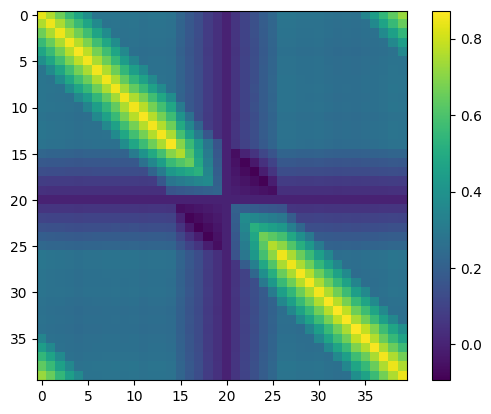

In [27]:
s1_ = xx1_ - np.outer(m1_, m1_)
im = plt.imshow(s1_)
cbar = plt.colorbar(im)

In [130]:
np.abs(xx1_ - xx1).max()

0.038531125

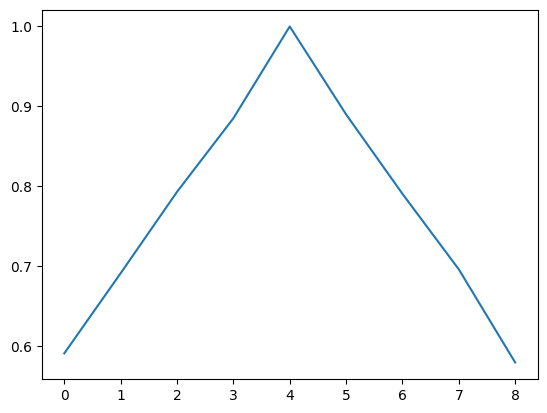

In [28]:
m1__ = m1_[20-5+1:20+5]
_ = plt.plot(m1__)

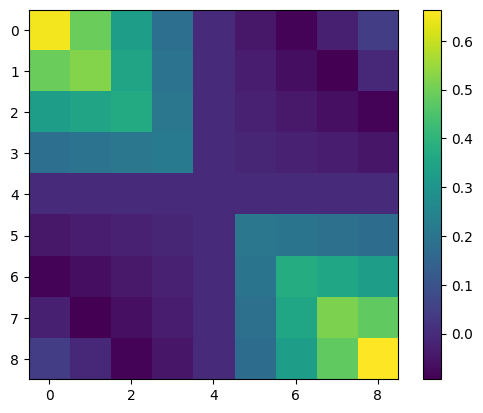

In [29]:
s1__ = s1_[20-5+1:20+5,20-5+1:20+5]
im = plt.imshow(s1__)
cbar = plt.colorbar(im)

[-8.8004629e-14  3.0943792e-02  5.6981731e-02  7.9247668e-02
  1.0767516e-01  1.3680336e-01  2.7926299e-01  1.2665845e+00
  1.5627795e+00]


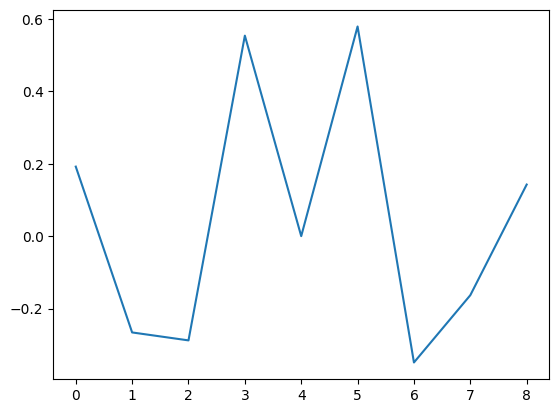

In [99]:
e, v = np.linalg.eigh(s1__)
print(e)
_ = plt.plot(v[:,3])

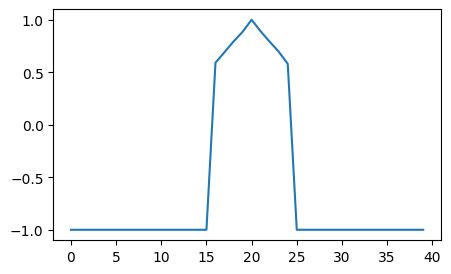

In [115]:
# wi_ = 1 * np.ones(2*5-1)
wi_ = m1__
# wi_ = np.random.randn(2*5-1)
# wi_[5:] = -1
wi = -np.ones(40)
wi[20-5+1:20+5] = wi_
fig, ax = plt.subplots(figsize=(5, 3)); _ = ax.plot(wi)

In [117]:
# discrete approx by normal
dscr = gaussian_cdf((wi_ @ m1__ - (wi.sum() - wi_.sum())) / np.sqrt(wi_ @ s1__ @ wi_)) - 0.5
print(dscr)
# normal
nrml = np.sqrt(2/np.pi) * s1[20] @ wi / np.sqrt(wi @ s1 @ wi)
# = np.sqrt(2/np.pi) * wi @ m1_ / np.sqrt(wi @ s1 @ wi)
print(nrml)
print(dscr / nrml)

0.5
-0.2938195
-1.7017251


In [90]:
np.sqrt(wi @ s1 @ wi)

24.397123

In [91]:
np.sqrt(wi_ @ s1__ @ wi_)

2.3211138

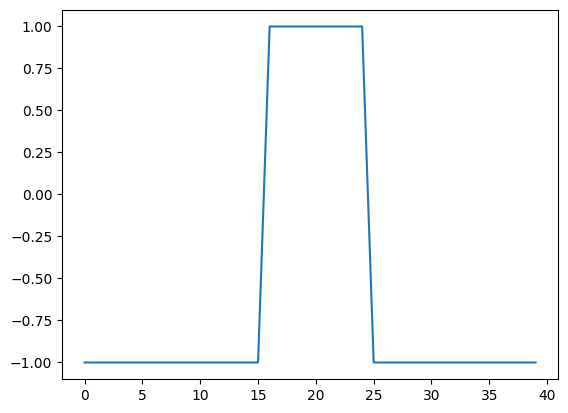

In [59]:
plt.plot(wi)

### Trying to understand $f$ at Gaussian init

Already simulated


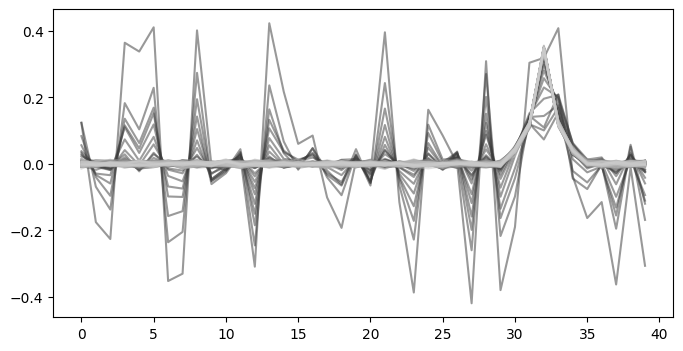

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  dataset_cls=datasets.NonlinearGPDataset,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=100,
)

config = config_.copy()
config.update(dict(
    num_hiddens=1, learning_rate=0.1, num_epochs=1000, 
    # df=100000,
    gain=3, 
))

weights, metrics = simulate_or_load(**config)
_ = plot_rf_evolution(weights, figsize=(8, 4))

In [2]:
dataset_high = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), num_dimensions=40, xi1=2, xi2=0.1, gain=100, num_exemplars=100000)
dataset_low = datasets.NLGPGaussianCloneDataset(key=jax.random.PRNGKey(0), num_dimensions=40, xi1=2, xi2=0.1, gain=100, num_exemplars=100000)
x, y = dataset_high[:100000]
x1h = x[y==1]
x0h = x[y==0]
x, y = dataset_low[:100000]
x1l = x[y==1]
x0l = x[y==0]

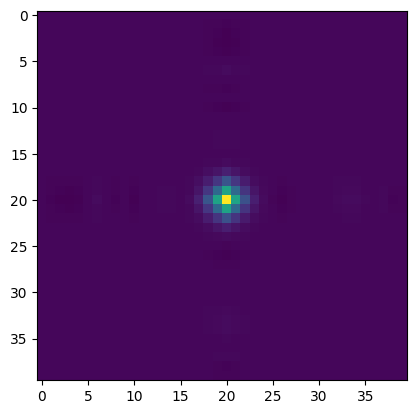

In [232]:
_ = plt.imshow(np.outer(m1h_, m1h_))

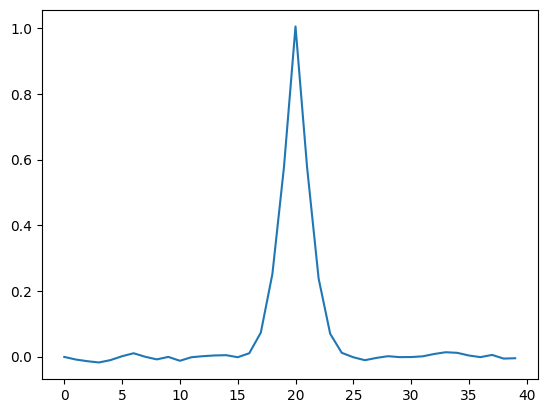

In [11]:
_ = plt.plot(xx1h_[20])

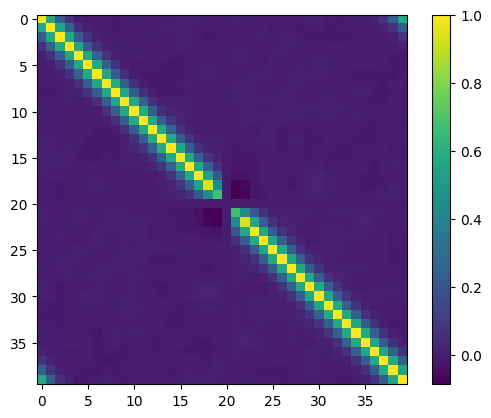

In [3]:
x1h_ = x1h[x1h[:,20] > 0.9]
m1h_ = np.mean(x1h_, axis=0)
xx1h_ = x1h_.T @ x1h_ / len(x1h_)
s1h_ = xx1h_ - np.outer(m1h_, m1h_)

x0h_ = x0h[x0h[:,20] > 0.9]
m0h_ = np.mean(x0h_, axis=0)
xx0h_ = x0h_.T @ x0h_ / len(x0h_)
s0h_ = xx0h_ - np.outer(m0h_, m0h_)

im = plt.imshow(s1h_)
cbar = plt.colorbar(im)

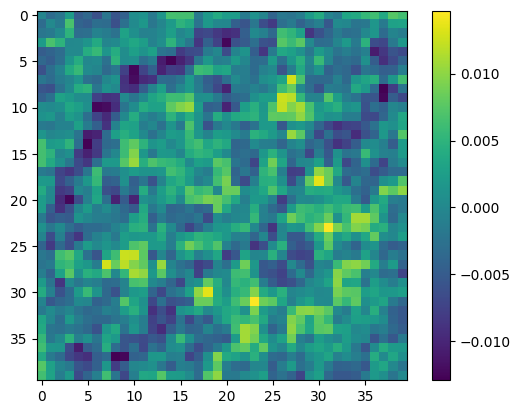

In [14]:
im = plt.imshow(xx1h_ - xx1h)
cbar = plt.colorbar(im)

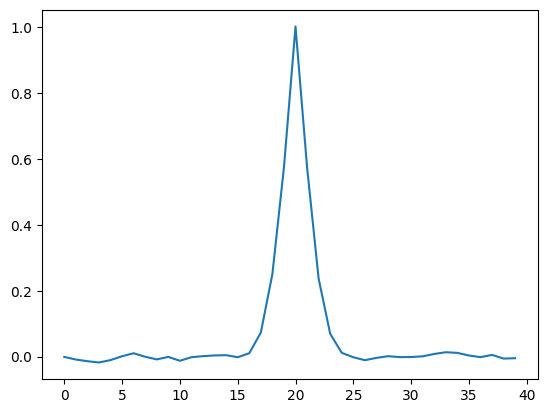

In [228]:
_ = plt.plot(m1h_)

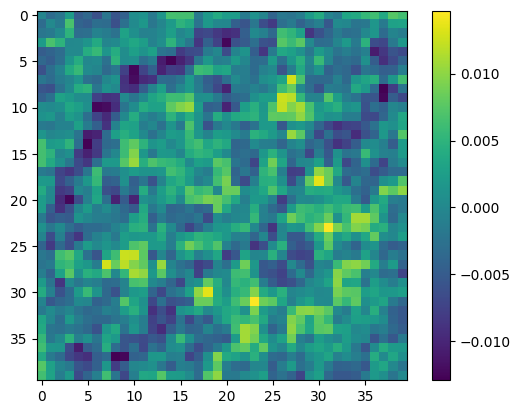

In [6]:
xx1h = x1h.T @ x1h / len(x1h)
im = plt.imshow(xx1h_ - xx1h)
cbar = plt.colorbar(im)

In [229]:
def f_approx(w, i, m, s):
    ind = (np.arange(len(w)) + i + 20) % len(w)
    w = w[ind].reshape(-1)
    z = (w.T @ m) / np.sqrt(w @ s @ w)
    return gaussian_cdf(z) - 0.5

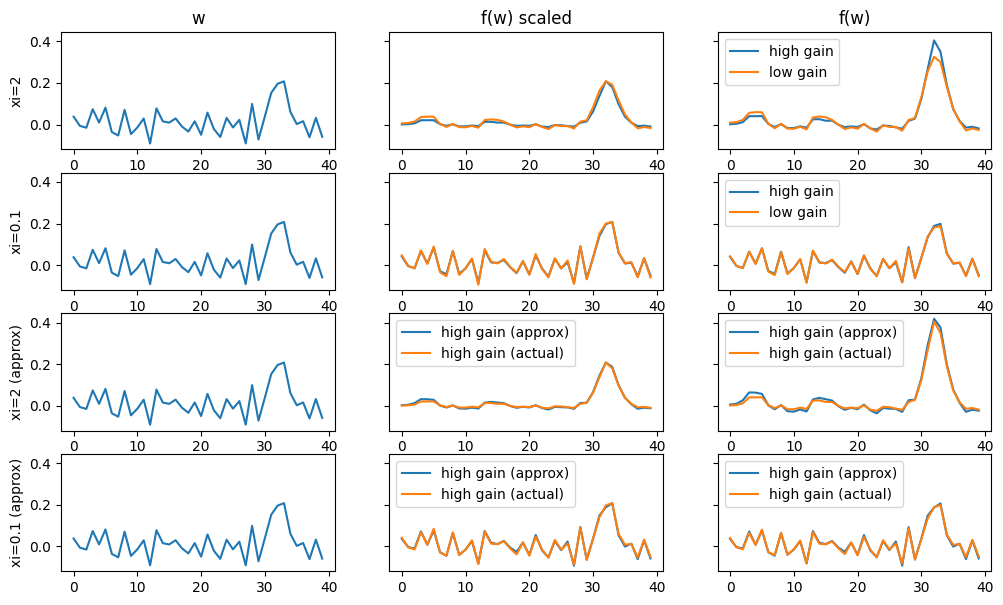

In [231]:
# w = jax.random.normal(key=jax.random.PRNGKey(0), shape=(40,1))
# w = jnp.cos(jnp.arange(40) * 2 * np.pi / 40).reshape(-1, 1)
# w = (-np.cos(np.arange(40)*10*np.pi/40) * np.exp(-(np.arange(40)-20)**2/3)).reshape(-1, 1)
# w = np.zeros((40,1)); w[15] = 2.1; w[16] = 1; w[17] = 1
# w = np.zeros((40,1)); w[15] = 2.1; w[25] = 1; w[35] = 1
# w = np.zeros((40,1)); w[15] = 2; w[25] = 1; w[35] = 1
# w = np.zeros((40,1)); w[15] = 1.5; w[25] = 1; w[35] = 1
w = weights[5].T
# w = np.zeros((40,1)); w[::4] = 1; w[2::4] = -1
fw1h = (x1h * ((x1h @ w) >= 0)).mean(axis=0)
fw0h = (x0h * ((x0h @ w) >= 0)).mean(axis=0)
fw1l = (x1l * ((x1l @ w) >= 0)).mean(axis=0)
fw0l = (x0l * ((x0l @ w) >= 0)).mean(axis=0)
fig, axs = plt.subplots(4, 3, figsize=(12, 7), sharey=True)
_ = axs[0,0].plot(w)
_ = axs[0,1].plot(fw1h * np.abs(w).max() / np.abs(fw1h).max(), label='high gain')
_ = axs[0,2].plot(fw1h, label='high gain')
_ = axs[0,1].plot(fw1l * np.abs(w).max() / np.abs(fw1l).max(), label='low gain')
_ = axs[0,2].plot(fw1l, label='low gain')
_ = axs[0,2].legend()
_ = axs[1,0].plot(w)
_ = axs[1,1].plot(fw0h * np.abs(w).max() / np.abs(fw0h).max(), label='high gain')
_ = axs[1,2].plot(fw0h, label='high gain')
_ = axs[1,1].plot(fw0l * np.abs(w).max() / np.abs(fw0l).max(), label='low gain')
_ = axs[1,2].plot(fw0l, label='low gain')
_ = axs[1,2].legend()
_ = axs[0,0].set_title('w')
_ = axs[0,1].set_title('f(w) scaled')
_ = axs[0,2].set_title('f(w)')
_ = axs[0,0].set_ylabel('xi=2')
_ = axs[1,0].set_ylabel('xi=0.1')
fw1h_approx = np.array([f_approx(w, i, m1h_, s1h_) for i in range(len(w))])
# fw1l_approx = np.array([f_approx(w, i, m1l_, s1l_) for i in range(len(w))])
fw0h_approx = np.array([f_approx(w, i, m0h_, s0h_) for i in range(len(w))])
# fw0l_approx = np.array([f_approx(w, i, m0l_, s0l_) for i in range(len(w))])
_ = axs[2,0].plot(w)
_ = axs[2,1].plot(fw1h_approx * np.abs(w).max() / np.abs(fw1h_approx).max(), label='high gain (approx)')
_ = axs[2,2].plot(fw1h_approx, label='high gain (approx)')
_ = axs[2,1].plot(fw1h * np.abs(w).max() / np.abs(fw1h).max(), label='high gain (actual)')
_ = axs[2,2].plot(fw1h, label='high gain (actual)')
_ = axs[2,1].legend()
_ = axs[2,2].legend()
_ = axs[2,0].set_ylabel('xi=2 (approx)')
_ = axs[3,0].plot(w)
_ = axs[3,1].plot(fw0h_approx * np.abs(w).max() / np.abs(fw0h_approx).max(), label='high gain (approx)')
_ = axs[3,2].plot(fw0h_approx, label='high gain (approx)')
_ = axs[3,1].plot(fw0h * np.abs(w).max() / np.abs(fw0h).max(), label='high gain (actual)')
_ = axs[3,2].plot(fw0h, label='high gain (actual)')
_ = axs[3,1].legend()
_ = axs[3,2].legend()
_ = axs[3,0].set_ylabel('xi=0.1 (approx)')

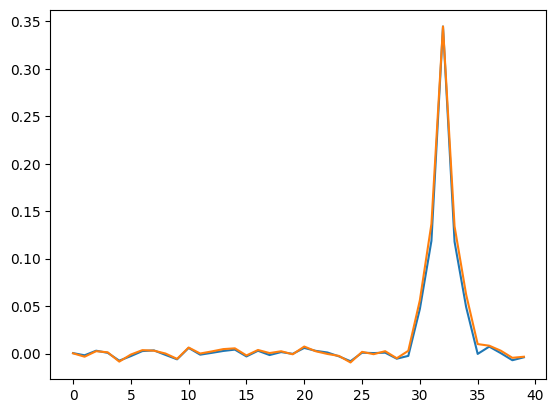

In [269]:
# xx1h = (x1h.T @ x1h) / len(x1h)
# xx0h = (x0h.T @ x0h) / len(x0h)
# plt.plot(w)
# fw = (0.1 * xx1h + xx0h) @ w
# plt.plot(fw * np.abs(w).max() / np.abs(fw).max())

### Trying to understand $k$ at Gaussian init

The condition I came up with seems way too strict.
I will have to relax this somehow to explain push towards localization early on.
Trying to understand what $f$ looks like early in training next.

November 24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [19]:
n = 40
# x = np.array(list(product([-1,1], repeat=n)))

In [46]:
def f_k(w, max=12):
    w = -np.sort(-w)
    # assume w is sorted
    w_abs = np.abs(w)
    for k in range(1,len(w)+1):
        x = np.array(list(product([-1,1], repeat=k)))
        m = np.abs(x @ w[:k]).min()
        print(m, w_abs[k:].sum())
        if m > w_abs[k:].sum():
            return k
        if k > max:
            return -1
    return len(w)

2.3366680757215987 31.278700606967686
0.28724455869847043 29.22927708994456
1.4978846188944264 27.44414791235166
0.1496016521160255 26.095864945573258
0.07780601564658673 24.76537948155324
0.14888971688670782 23.435605952762543
0.07358143614021206 22.257219875758643
0.023000216056499934 21.204723299584955
0.002983805514786275 20.315452282980907
0.021947514516337918 19.54461502609474
0.00045366639684907284 18.820409126117323
0.0025810596628108584 18.176640122821556
0.0002128059000181537 17.5372001170291


-1

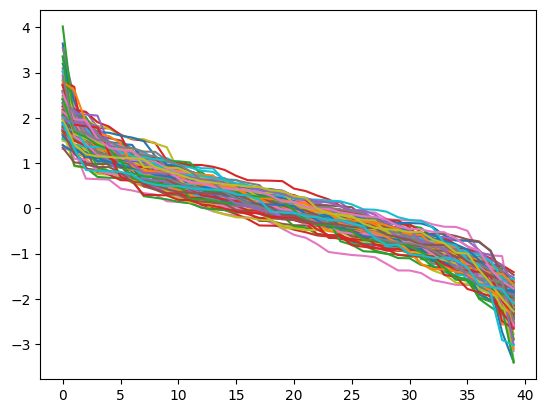

In [47]:
num_samples = 100
w = -np.sort(-np.random.normal(size=(num_samples,n)), axis=1)
_ = plt.plot(w.T)
f_k(w[0])

1.0 1.0937337934806106
0.4933358513607894 0.5870696448413998
0.013328297278420997 0.08040549620218951
0.013328240260882529 0.08040543918465101
0.013328183243344038 0.08040538216711252
0.013328182700029842 0.08040538162379832
0.013328182156715645 0.08040538108048412
0.01332818215538667 0.0804053810791551
0.013328182154057643 0.08040538107782608
0.013328182154057643 0.08040538107782608
0.013328182154057643 0.08040538107782608
0.013328182154057733 0.08040538107782608
0.013328182154057733 0.08040538107782608


-1

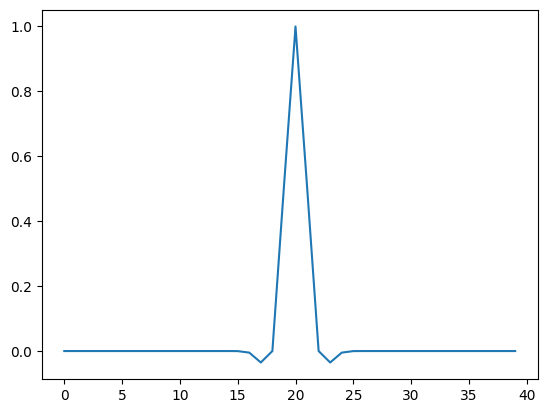

In [50]:
w = -np.cos(np.arange(n)*10*np.pi/n) * np.exp(-(np.arange(n)-20)**2/3)
_ = plt.plot(w)
f_k(w)

In [45]:
w[np.abs(w) > 0.05]

array([-0.07452851,  0.55069531,  1.        ,  0.55069531, -0.07452851])

### November 22-23

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
n = 20
x = np.array(list(product([-1,1], repeat=n)))

In [3]:
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  dataset_cls=datasets.NonlinearGPDataset,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=100,
)

config = config_.copy()
config.update(dict(
    num_hiddens=1, learning_rate=0.1, num_epochs=1000, 
    # df=100000,
    gain=3, 
))

weights, metrics = simulate_or_load(**config)
w = weights[:,0,::2]

Already simulated


In [16]:
# single w
w = np.abs(w)
w = w[np.argsort(w)[::-1]]
p = np.mean(x[x @ w >= 0], axis=0)
p

array([0.66169739, 0.25057983, 0.23191071, 0.17990875, 0.15484619,
       0.12498474, 0.09945679, 0.09629822, 0.09148407, 0.0851593 ,
       0.08209229, 0.08104706, 0.07471466, 0.05706024, 0.05375671,
       0.04060364, 0.03862   , 0.03842926, 0.03588867, 0.02357483])

In [18]:
# multiple samples of w
# s = 1000
# w = np.random.normal(size=(s,n))
# w = np.random.rand(s,n)
# w[:,0] *= 2
# w = np.cos(2*np.pi*np.arange(n)/n)
w = np.abs(w)
w = np.apply_along_axis(lambda w_: w_[np.argsort(w_)[::-1]], 1, w)
p = np.apply_along_axis(lambda w_: np.mean(x[x @ w_ >= 0], axis=0), 1, w)

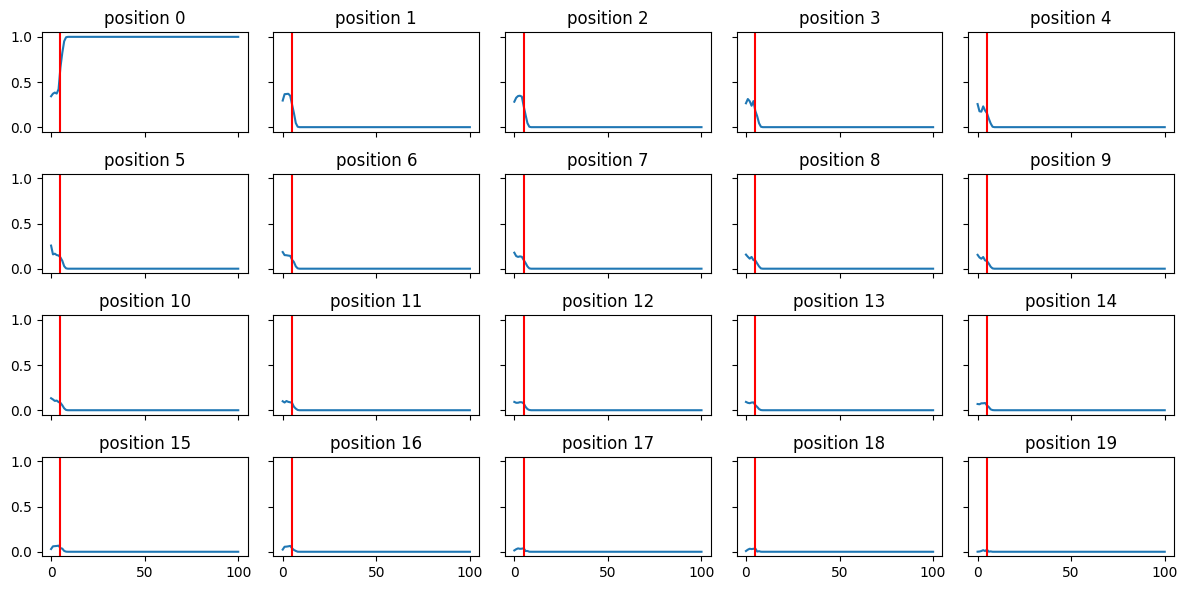

In [27]:
fig, axs = plt.subplots(4, 5, figsize=(12, 6), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(p[:,i])
    ax.set_title(f'position {i}')
    ax.axvline(5, color='r')
fig.tight_layout()

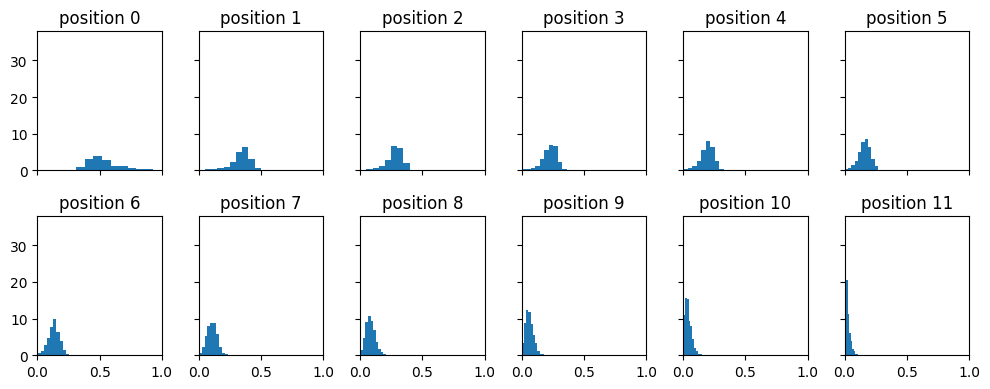

In [93]:
fig, axs = plt.subplots(2, 6, figsize=(10, 4), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.hist(p[:,i], density=True)
    ax.set_title(f'position {i}')
    ax.set_xlim(0,1)
fig.tight_layout()